In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import finpy_tse as fpy
import xgboost as xgb
import lightgbm as lgb
import gymnasium as gym
import hashlib

from scipy.stats import spearmanr
from statsmodels.tsa.stattools import adfuller, kpss
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_squared_error
from stable_baselines3 import PPO
from gymnasium import spaces

In [3]:
def import_data(symbols_input, symbols_start_date, symbols_end_date):
    results = {}

    for x in symbols_input:
        # Fetch USD/IRR exchange rate data from FinaPy
        if x == 'دلار':
            USD_RIAL = fpy.Get_USD_RIAL(
                start_date=symbols_start_date,
                end_date=symbols_end_date,
                ignore_date=False,
                show_weekday=False,
                double_date=False
            )
            results[x] = USD_RIAL
        # Fetch main index (CWI) data
        elif x == 'شاخص کل':
            CWI = fpy.Get_CWI_History(
                start_date=symbols_start_date,
                end_date=symbols_end_date,
                ignore_date=False,
                just_adj_close=False,
                show_weekday=False,
                double_date=False
            )
            results[x] = CWI
        # Fetch price history for a listed stock symbol on TSE
        else:
            STOCK = fpy.Get_Price_History(
                stock=x,
                start_date=symbols_start_date,
                end_date=symbols_end_date,
                ignore_date=False,
                adjust_price=False,
                show_weekday=False,
                double_date=False
            )
            results[x] = STOCK

    return results

In [4]:
data = import_data(  symbols_input = ['شپنا','شاخص کل','خودرو']    # Enter symbols
                   , symbols_start_date = '1403-01-01'              # Enter start date
                   , symbols_end_date = '1403-12-30')               # Enter end date

with pd.ExcelWriter("Initial_Data.xlsx", engine="xlsxwriter") as writer:
    for sheet_name, df in data.items():
        df.to_excel(writer, sheet_name=sheet_name)

In [5]:
def calculate_data_index(data, window, data_price_type, risk_free_rate):
    
    #Calculates return and risk metrics for each symbol in the data dictionary.

    results = {}

    for symbol, df in data.items():
        df = df.copy()  # Work on a copy to avoid modifying original

        # Fill missing data
        df[data_price_type] = df[data_price_type].fillna(method="ffill")

        # Simple return
        df["simple_return"] = df[data_price_type].pct_change()

        # Log return
        df["log_return"] = np.log(df[data_price_type] / df[data_price_type].shift(1))

        # Cumulative return
        df["cumulative_return"] = (1 + df["simple_return"]).cumprod() - 1

        # Rolling average return
        df["rolling_avg_return"] = df["log_return"].rolling(window).mean()

        # Rolling volatility
        df["rolling_volatility"] = df["log_return"].rolling(window).std()

        # Rolling Sharpe Ratio
        df["rolling_sharpe"] = (df["rolling_avg_return"] - risk_free_rate) / df["rolling_volatility"]

        # Max Drawdown
        cumulative = (1 + df["simple_return"]).cumprod()
        df["rolling_max"] = cumulative.cummax()
        df["drawdown"] = (cumulative - df["rolling_max"]) / df["rolling_max"]
        df["max_drawdown"] = df["drawdown"].rolling(window).min()

        # Drop missing rows caused by rolling calculations
        df.dropna(inplace=True)

        # Save results
        results[symbol] = df

    return results

In [6]:
data_index = calculate_data_index(data,
                              window=20,                  # window is depends on your goal 
                              data_price_type='Close',    # (short-term trading,standard,long-term investing)(5,20,100)
                              risk_free_rate=0.0)         # data_price_type : 'Open'   'Close'  'High'   'Low'
                                                          # for daily risk-free rate,The risk-free rate is, 
                                                          # the "baseline return" you could get with no risk,
                                                          # It’s used in Sharpe Ratio to compare your return ,
                                                          # above that safe baseline.

In [7]:
print(data_index)

{'شپنا':             Open  High   Low  Close  Final     Volume          Value    No  \
J-Date                                                                       
1403-02-05  6120  6240  6080   6180   6130   54683024   335472646030  4207   
1403-02-08  6140  6200  6040   6050   6080   55877755   339881709370  4348   
1403-02-09  6040  6040  5870   5950   5940   58246919   346031011200  4409   
1403-02-10  5960  5980  5920   5930   5940   59512053   353769674120  3282   
1403-02-11  5910  5940  5850   5930   5880   56408637   331632011440  3496   
...          ...   ...   ...    ...    ...        ...            ...   ...   
1403-12-18  5180  5210  5040   5040   5060  188571811   953574550970  5070   
1403-12-19  5000  5040  4910   4980   4950  256285271  1268368647410  6516   
1403-12-20  4950  5090  4920   4950   4970  132102985   656820285030  4401   
1403-12-21  4980  5000  4830   4830   4850  144071715   698705122630  3562   
1403-12-22  4740  4960  4710   4920   4880  116859810  

In [8]:
def plot_data_index(data_index, symbol, column, color):
    # Check if symbol exists
    if symbol not in data_index:
        print(f" Symbol '{symbol}' not found in metrics.")
        print(f" Available symbols: {list(data_index.keys())}")
        return

    df = data_index[symbol]

    # Check if column exists in that symbol's DataFrame
    if column not in df.columns:
        print(f" Column '{column}' not found in DataFrame for {symbol}.")
        print(f" Available columns: {df.columns.tolist()}")
        return

    # Plot the data
    df[column].plot(label=symbol, color=color, figsize=(16, 6))
    plt.xlabel('Date')
    plt.ylabel(column.capitalize())
    plt.title(f'{symbol} ({column})')
    plt.grid()
    plt.legend()
    plt.show()


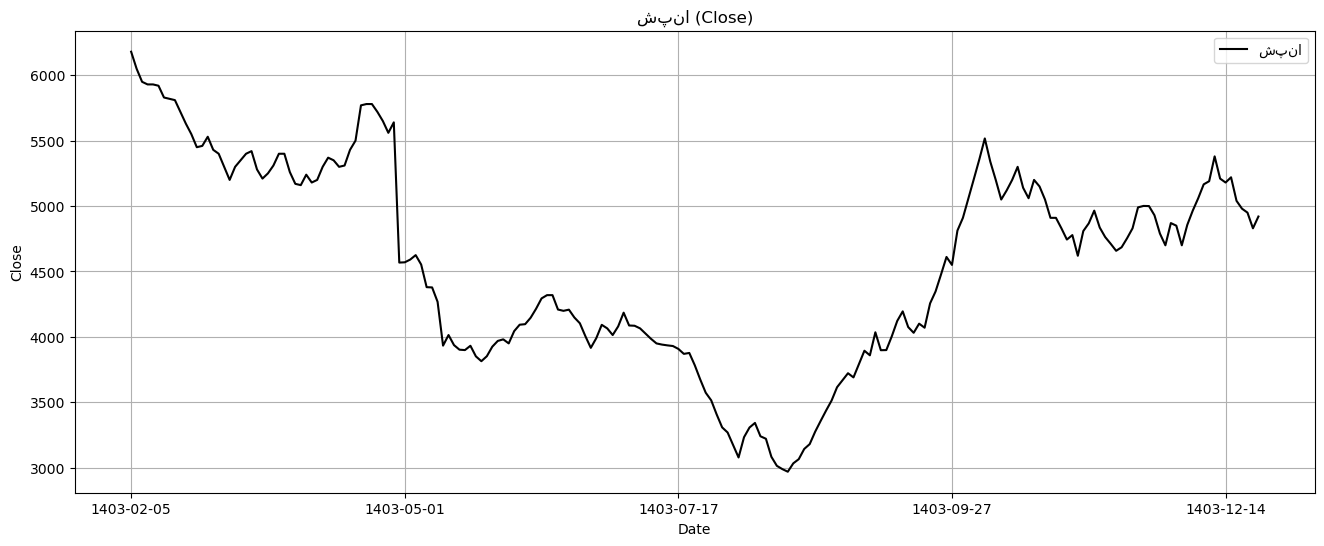

In [9]:
# Plot
plot_data_index(data_index, symbol='شپنا'
                          , column='Close'
                          , color='black' )


In [16]:
# Store processed data for ML
processed_data = {}

# Store which features passed stationarity per symbol
stationary_features_by_symbol = {}

def adf_test(series):
    try:
        if series.nunique() <= 1:
            return False
        result = adfuller(series.dropna())
        return result[1] < 0.05
    except:
        return False

def kpss_test(series):
    try:
        if series.nunique() <= 1:
            return False
        result = kpss(series.dropna(), regression='c', nlags='auto')
        return result[1] >= 0.05
    except:
        return False

# Data preprocessing function for ML
def data_preprocessing(data, num_lags, train_test_split):
    x, y = [], []
    for i in range(len(data) - num_lags):
        x.append(data[i:i + num_lags])
        y.append(data[i + num_lags])
    x = np.array(x)
    y = np.array(y)
    split_index = int(train_test_split * len(x))
    return x[:split_index], y[:split_index], x[split_index:], y[split_index:]

# List of features (indexes) to check
columns_to_test = ['simple_return', 'log_return', 'cumulative_return',
                   'rolling_avg_return', 'rolling_volatility', 'rolling_sharpe',
                   'rolling_max', 'max_drawdown', 'drawdown']

# Main loop
for symbol, df in data_index.items():
    stationary_features = []

    for column in columns_to_test:
        if column in df.columns:
            series = df[column].dropna()
            is_adf_stationary = adf_test(series)
            is_kpss_stationary = kpss_test(series)

            if is_adf_stationary or is_kpss_stationary:
                stationary_features.append(column)

                # Preprocess for ML and store
                x_train, y_train, x_test, y_test = data_preprocessing(series.values,
                                                                     num_lags=10,
                                                                     train_test_split=0.8)

                processed_data[(symbol, column)] = {
                    "x_train": x_train,
                    "y_train": y_train,
                    "x_test": x_test,
                    "y_test": y_test
                }

    # Save which features are stationary for this symbol
    stationary_features_by_symbol[symbol] = stationary_features


In [17]:
print(stationary_features_by_symbol)

{'شپنا': ['simple_return', 'log_return', 'rolling_avg_return', 'rolling_volatility', 'rolling_sharpe'], 'شاخص کل': ['simple_return', 'log_return'], 'خودرو': ['simple_return', 'log_return', 'rolling_avg_return', 'rolling_volatility', 'rolling_sharpe', 'max_drawdown']}


In [18]:
print(processed_data)

{('شپنا', 'simple_return'): {'x_train': array([[ 0.00487805, -0.0210356 , -0.01652893, ..., -0.00171527,
        -0.00171821, -0.01549053],
       [-0.0210356 , -0.01652893, -0.00336134, ..., -0.00171821,
        -0.01549053, -0.01573427],
       [-0.01652893, -0.00336134,  0.        , ..., -0.01549053,
        -0.01573427, -0.01420959],
       ...,
       [ 0.02966185,  0.02880737,  0.02986746, ...,  0.015625  ,
         0.01923077, -0.03018868],
       [ 0.02880737,  0.02986746, -0.03208265, ...,  0.01923077,
        -0.03018868, -0.0155642 ],
       [ 0.02986746, -0.03208265, -0.02621723, ..., -0.03018868,
        -0.0155642 ,  0.02766798]]), 'y_train': array([-0.01573427, -0.01420959, -0.01801802,  0.00183486,  0.01282051,
       -0.01808318, -0.00552486, -0.01851852, -0.01886792,  0.01923077,
        0.00943396,  0.00934579,  0.0037037 , -0.02583026, -0.01325758,
        0.00767754,  0.01142857,  0.01694915,  0.        , -0.02592593,
       -0.01711027, -0.00193424,  0.01550388, -

In [19]:
# Train the model and evaluate performance on test data
def train_and_evaluate(model, x_train, y_train, x_test, y_test):
    model.fit(x_train, y_train)               # Train model
    y_pred = model.predict(x_test)            # Predict on test data
    r2 = r2_score(y_test, y_pred)             # Calculate R-squared (accuracy)
    mse = mean_squared_error(y_test, y_pred)  # Calculate Mean Squared Error (error)
    return {"model": model, "r2": r2, "mse": mse, "y_pred": y_pred}

# Run multiple models on all processed datasets
def run_models_on_processed_data(processed_data):
    all_results = {}  # Store results for each (symbol, feature)

    # Define models to test
    models = {
        "LinearRegression": LinearRegression(),
        "RandomForest": RandomForestRegressor(n_estimators=100, random_state=42),
        "XGBoost": xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42),
        "GradientBoosting": GradientBoostingRegressor(n_estimators=100, random_state=42),
        "LightGBM": lgb.LGBMRegressor(n_estimators=100, random_state=42)
    }

    # Loop through each symbol and feature dataset
    for (symbol, feature), data_dict in processed_data.items():
        x_train, y_train = data_dict["x_train"], data_dict["y_train"]
        x_test, y_test = data_dict["x_test"], data_dict["y_test"]
        results = {}
        # Train and evaluate each model
        for name, model in models.items():
            results[name] = train_and_evaluate(model, x_train, y_train, x_test, y_test)

        all_results[(symbol, feature)] = results

    return all_results

In [20]:
def results_to_dataframe(all_results):
    rows = []
    for (symbol, feature), model_results in all_results.items():
        for model_name, metrics in model_results.items():
            rows.append({
                "Symbol": symbol,
                "Feature": feature,
                "Model": model_name,
                "R2_Score": metrics["r2"],
                "MSE": metrics["mse"]
            })
    df_results = pd.DataFrame(rows)
    return df_results
all_results = run_models_on_processed_data(processed_data)
df_results = results_to_dataframe(all_results)
df_results.to_excel("model_results.xlsx", index=False, sheet_name="Model_Results")
print(df_results)

   Symbol        Feature             Model  R2_Score       MSE
0    شپنا  simple_return  LinearRegression -0.058729  0.000493
1    شپنا  simple_return      RandomForest -0.061217  0.000494
2    شپنا  simple_return           XGBoost -0.138163  0.000530
3    شپنا  simple_return  GradientBoosting -0.159374  0.000540
4    شپنا  simple_return          LightGBM -0.251516  0.000583
..    ...            ...               ...       ...       ...
60  خودرو   max_drawdown  LinearRegression  0.909569  0.000068
61  خودرو   max_drawdown      RandomForest  0.382636  0.000465
62  خودرو   max_drawdown           XGBoost  0.603881  0.000299
63  خودرو   max_drawdown  GradientBoosting  0.693205  0.000231
64  خودرو   max_drawdown          LightGBM -0.337800  0.001009

[65 rows x 5 columns]


In [21]:
def get_min_error_per_feature(all_results, metric='mse'):        # metric= 'mse' 
    records = []

    for (symbol, feature), results in all_results.items():
        best_model = None
        best_metric_value = None

        for model_name, result in results.items():
            value = result[metric]
            if best_metric_value is None or value < best_metric_value:
                best_metric_value = value
                best_model = model_name

        records.append({
            "Symbol": symbol,
            "Feature": feature,
            "Best_Model": best_model,
            f"Min_{metric}": best_metric_value
        })

    df = pd.DataFrame(records)
    return df
    
df_min_errors = get_min_error_per_feature(all_results, metric='mse')    # metric= 'mse' 
print(df_min_errors)


     Symbol             Feature        Best_Model       Min_mse
0      شپنا       simple_return  LinearRegression  4.928614e-04
1      شپنا          log_return  LinearRegression  4.922476e-04
2      شپنا  rolling_avg_return  LinearRegression  2.382897e-06
3      شپنا  rolling_volatility  LinearRegression  6.987192e-07
4      شپنا      rolling_sharpe  LinearRegression  5.161583e-03
5   شاخص کل       simple_return          LightGBM  1.146706e-04
6   شاخص کل          log_return          LightGBM  1.091107e-04
7     خودرو       simple_return  GradientBoosting  5.910946e-04
8     خودرو          log_return  GradientBoosting  5.326102e-04
9     خودرو  rolling_avg_return  LinearRegression  2.924293e-06
10    خودرو  rolling_volatility  LinearRegression  1.116125e-06
11    خودرو      rolling_sharpe          LightGBM  6.107072e-03
12    خودرو        max_drawdown  LinearRegression  6.817270e-05


In [22]:
print(stationary_features_by_symbol)     

{'شپنا': ['simple_return', 'log_return', 'rolling_avg_return', 'rolling_volatility', 'rolling_sharpe'], 'شاخص کل': ['simple_return', 'log_return'], 'خودرو': ['simple_return', 'log_return', 'rolling_avg_return', 'rolling_volatility', 'rolling_sharpe', 'max_drawdown']}


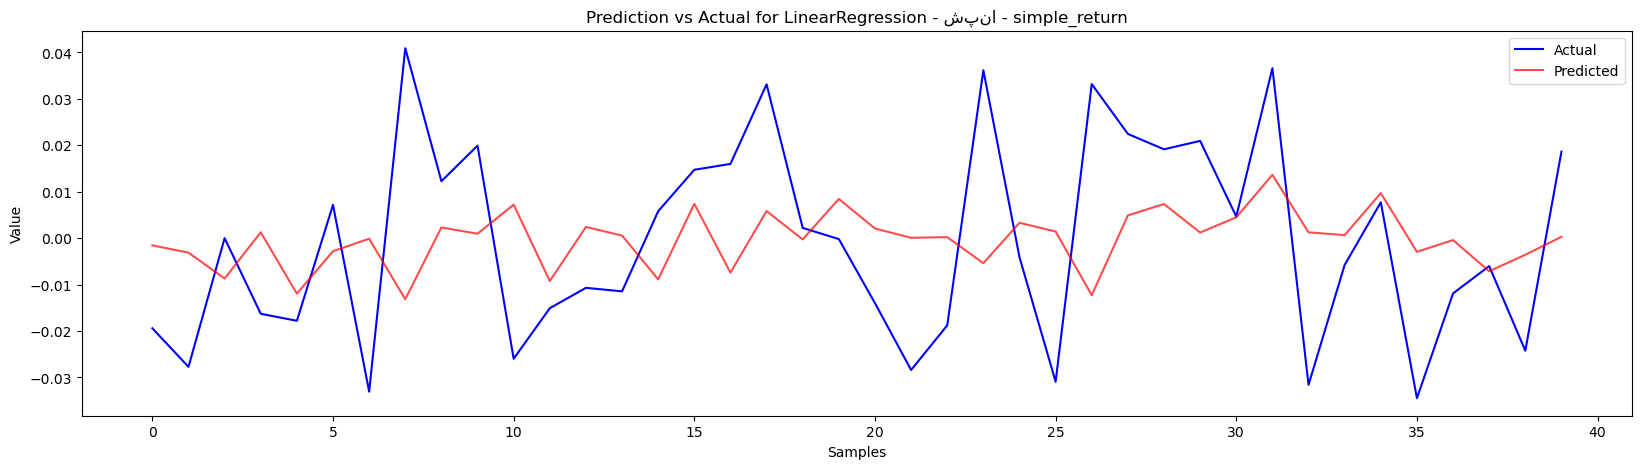

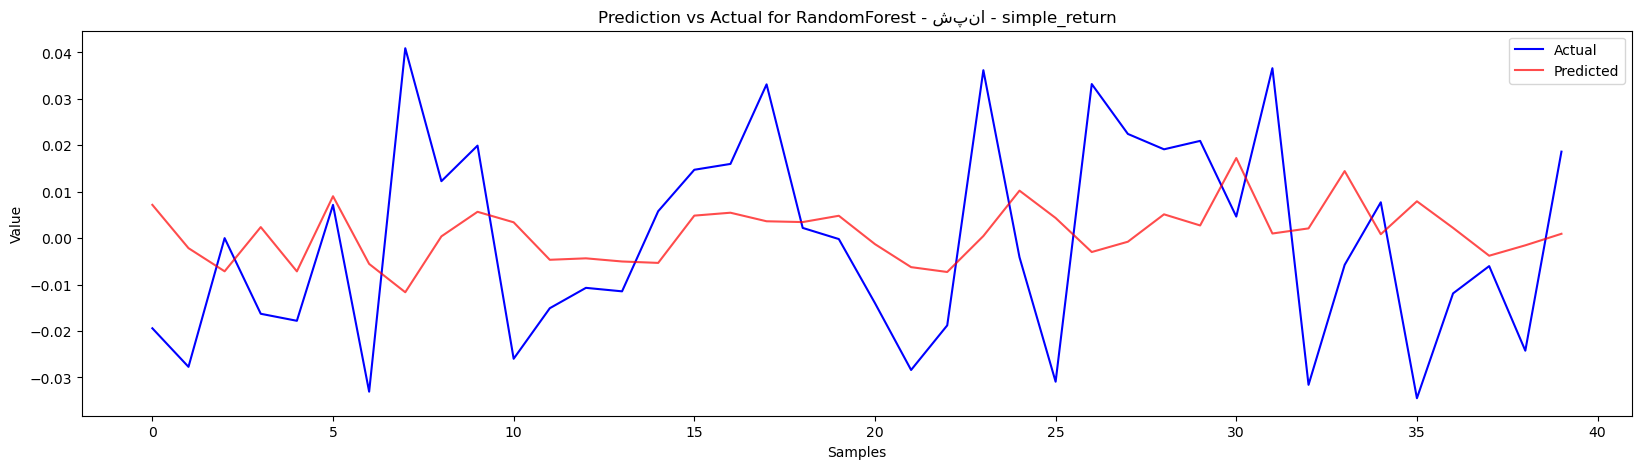

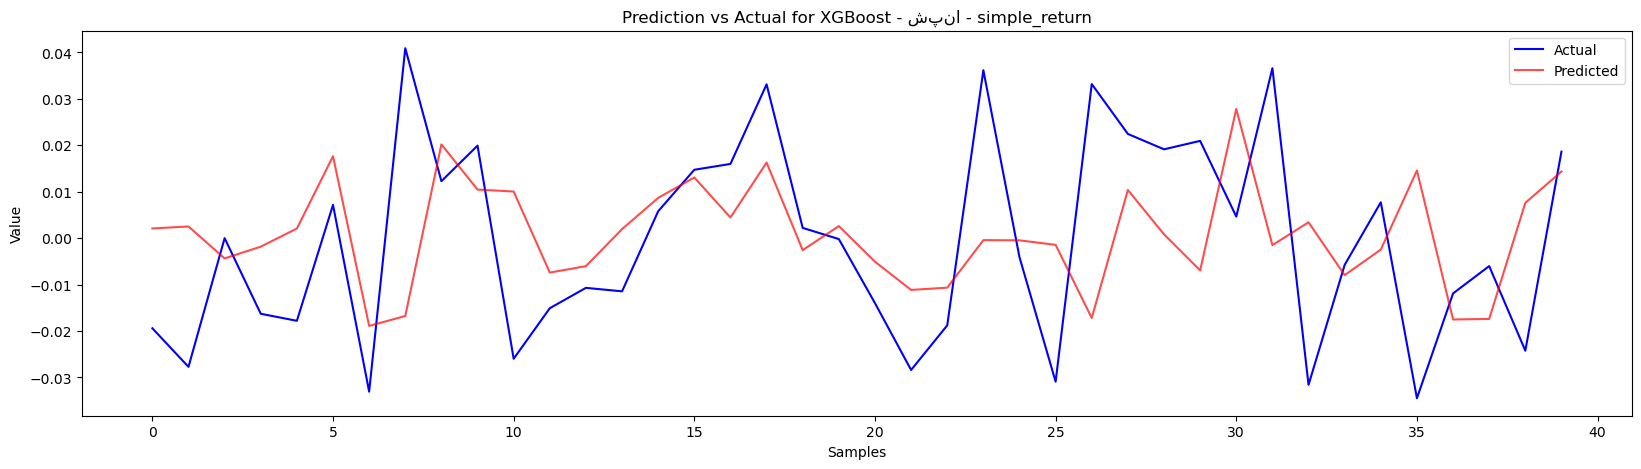

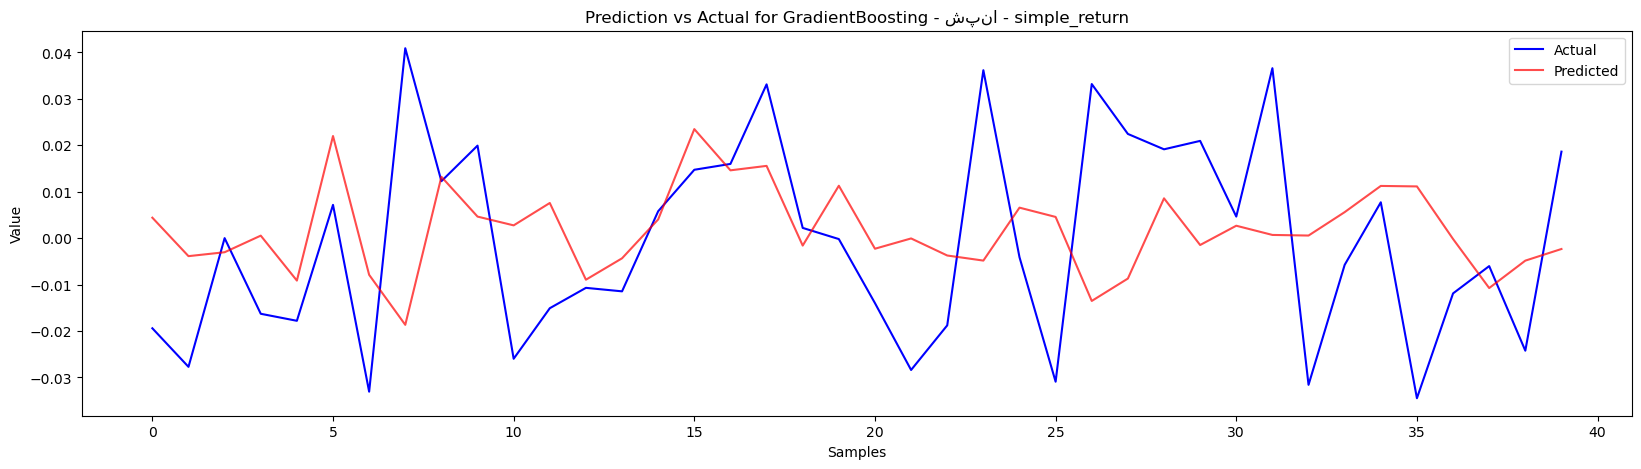

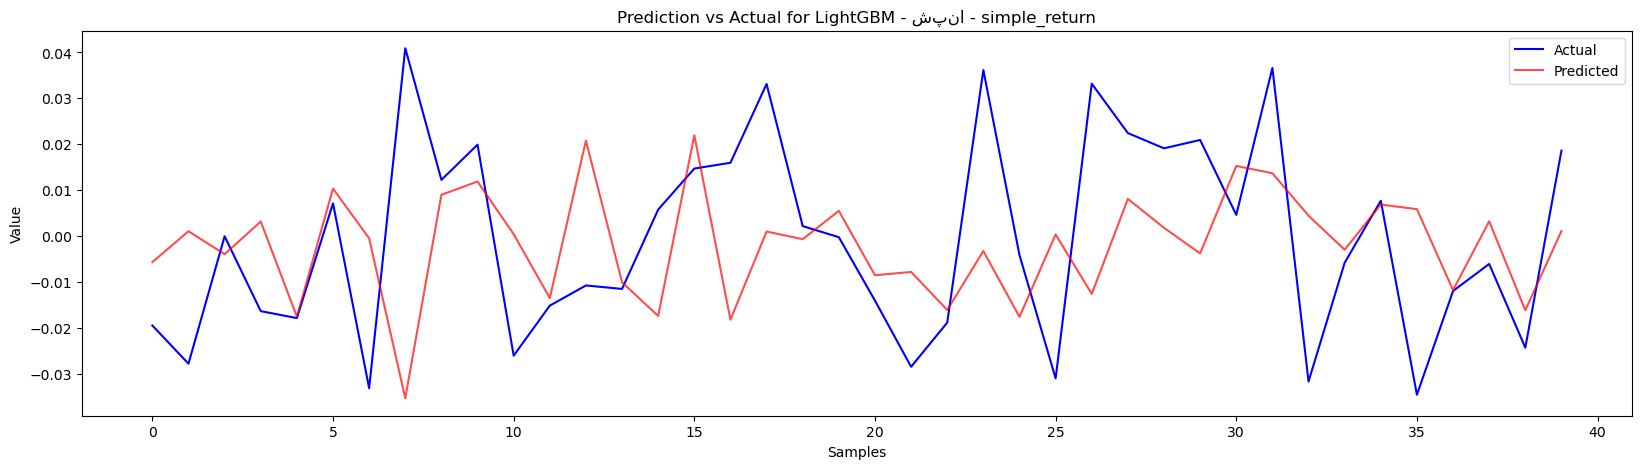

In [23]:
def plot_predictions(y_test, y_pred, model_name, symbol, feature):
    plt.figure(figsize=(20, 5))
    plt.plot(y_test, label='Actual', color='blue')
    plt.plot(y_pred, label='Predicted', color='red', alpha=0.7)
    plt.title(f'Prediction vs Actual for {model_name} - {symbol} - {feature}')
    plt.xlabel('Samples')
    plt.ylabel('Value')
    plt.legend()
    plt.show()
    
symbol = 'شپنا'     
feature = 'simple_return'

for model_name, results in all_results[(symbol, feature)].items():
    y_test = processed_data[(symbol, feature)]["y_test"]
    y_pred = results["y_pred"]
    plot_predictions(y_test, y_pred, model_name, symbol, feature)
    

In [27]:
class RandomForestHyperparamEnv(gym.Env):
    def __init__(self, x_train, y_train, x_test, y_test):
        """
        Initialize the custom Gym environment for optimizing RandomForest hyperparameters.

        Parameters:
            x_train (ndarray): Training feature set
            y_train (ndarray): Training labels
            x_test (ndarray): Test feature set
            y_test (ndarray): Test labels
        """
        super(RandomForestHyperparamEnv, self).__init__()
        self.x_train = x_train
        self.y_train = y_train
        self.x_test = x_test
        self.y_test = y_test

        # Actions: [n_estimators_scaled, max_depth_scaled] ∈ [0, 1]^2
        self.action_space = spaces.Box(low=0.0, high=1.0, shape=(2,), dtype=np.float32)
        
        # Dummy observation space (not used)
        self.observation_space = spaces.Box(low=0.0, high=1.0, shape=(1,), dtype=np.float32)

        # Dictionary for caching model evaluation results for specific hyperparameter combinations
        self.cache = {}

    def reset(self, seed=None, options=None):
        """
        Reset the environment (dummy, one-step episode).
        """
        super().reset(seed=seed)
        self.current_obs = np.array([0.5], dtype=np.float32)
        return self.current_obs, {}

    def step(self, action):
        """
        Perform a step in the environment by evaluating the hyperparameters
        corresponding to the given action.

        Parameters:
            action (array): Normalized hyperparameters in [0, 1]

        Returns:
            observation (array), reward (float), terminated (bool), truncated (bool), info (dict)
        """
        # Convert scaled actions to actual hyperparameter values
        n_estimators = int(10 + action[0] * 90)     # Range: 10 to 100
        max_depth = int(2 + action[1] * 18)         # Range: 2 to 20

        # Create a unique cache key using a hash of the parameters
        key_str = f"{n_estimators}_{max_depth}"
        key_hash = hashlib.md5(key_str.encode()).hexdigest()

        if key_hash in self.cache:
            # Use cached result if already evaluated
            mse = self.cache[key_hash]
        else:
            # Train and evaluate the model
            model = RandomForestRegressor(
                n_estimators=n_estimators,
                max_depth=max_depth,
                random_state=42,
                n_jobs=-1
            )
            model.fit(self.x_train, self.y_train)
            y_pred = model.predict(self.x_test)
            mse = mean_squared_error(self.y_test, y_pred)
            self.cache[key_hash] = mse  # Store result in cache

        reward = -mse  # The lower the MSE, the higher the reward

        terminated = True  # One-step environment
        truncated = False
        info = {
            'n_estimators': n_estimators,
            'max_depth': max_depth,
            'mse': mse
        }

        return self.current_obs, reward, terminated, truncated, info

def optimize_rf_with_rl(processed_data, timesteps=20000):
    """
    Optimize RandomForest hyperparameters (n_estimators and max_depth)
    for each (symbol, feature) combination using PPO reinforcement learning.

    Parameters:
        processed_data (dict): Dictionary containing training and testing splits 
                               for each (symbol, feature).
        timesteps (int): Number of training steps for PPO agent.

    Returns:
        dict: Best hyperparameters and MSE for each (symbol, feature) pair.
    """
    best_params = {}

    for (symbol, feature), data in processed_data.items():
        x_train = data["x_train"]
        y_train = data["y_train"]
        x_test = data["x_test"]
        y_test = data["y_test"]

        print(f"\n... Optimizing RandomForest for {symbol} - {feature}")

        env = RandomForestHyperparamEnv(x_train, y_train, x_test, y_test)
        model = PPO("MlpPolicy", env, verbose=0, learning_rate=0.0003, n_steps=2048)
        model.learn(total_timesteps=timesteps)

        obs, _ = env.reset()
        done = False
        while not done:
            action, _ = model.predict(obs)
            obs, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated

        best_params[(symbol, feature)] = {
            "best_n_estimators": info['n_estimators'],
            "best_max_depth": info['max_depth'],
            "best_mse": info['mse']
        }

    return best_params

# Run the optimization and store results
best_rf_results = optimize_rf_with_rl(processed_data, timesteps=20000)

# Convert to DataFrame
df_rf = pd.DataFrame([
    {
        "Symbol": s,
        "Feature": f,
        "Best_n_estimators": d["best_n_estimators"],
        "Best_max_depth": d["best_max_depth"],
        "Best_MSE": d["best_mse"]
    }
    for (s, f), d in best_rf_results.items()
])

# Save to Excel
df_rf.to_excel("rf_results.xlsx", index=False, sheet_name="RF_Results")

# Sort results by best MSE
print(df_rf.sort_values(by="Best_MSE"))


... Optimizing RandomForest for شپنا - simple_return

... Optimizing RandomForest for شپنا - log_return

... Optimizing RandomForest for شپنا - rolling_avg_return

... Optimizing RandomForest for شپنا - rolling_volatility

... Optimizing RandomForest for شپنا - rolling_sharpe

... Optimizing RandomForest for شاخص کل - simple_return

... Optimizing RandomForest for شاخص کل - log_return

... Optimizing RandomForest for خودرو - simple_return

... Optimizing RandomForest for خودرو - log_return

... Optimizing RandomForest for خودرو - rolling_avg_return

... Optimizing RandomForest for خودرو - rolling_volatility

... Optimizing RandomForest for خودرو - rolling_sharpe

... Optimizing RandomForest for خودرو - max_drawdown
     Symbol             Feature  Best_n_estimators  Best_max_depth  \
3      شپنا  rolling_volatility                100              20   
10    خودرو  rolling_volatility                100              19   
9     خودرو  rolling_avg_return                 10              

In [29]:
class XGBHyperparamEnv(gym.Env):
    def __init__(self, x_train, y_train, x_test, y_test):
        """
        Initialize the custom Gym environment for optimizing XGBoost hyperparameters.

        Parameters:
            x_train (ndarray): Training feature set
            y_train (ndarray): Training labels
            x_test (ndarray): Test feature set
            y_test (ndarray): Test labels
        """
        super(XGBHyperparamEnv, self).__init__()
        self.x_train = x_train
        self.y_train = y_train
        self.x_test = x_test
        self.y_test = y_test

        # Action space: [n_estimators, max_depth, learning_rate] ∈ [0, 1]^3
        self.action_space = spaces.Box(low=0.0, high=1.0, shape=(3,), dtype=np.float32)

        # Observation space (dummy, not used in this stateless setup)
        self.observation_space = spaces.Box(low=0.0, high=1.0, shape=(1,), dtype=np.float32)

        # Dictionary to cache evaluation results for hyperparameter combinations
        self.cache = {}

    def reset(self, seed=None, options=None):
        """
        Reset the environment (dummy, one-step episode).
        """
        super().reset(seed=seed)
        self.current_obs = np.array([0.5], dtype=np.float32)
        return self.current_obs, {}

    def step(self, action):
        """
        Perform a step in the environment by evaluating the hyperparameters
        corresponding to the given action.

        Parameters:
            action (array): Normalized hyperparameters in [0, 1]

        Returns:
            observation (array), reward (float), terminated (bool), truncated (bool), info (dict)
        """
        # Convert normalized actions to real hyperparameter values
        n_estimators = int(50 + action[0] * 150)         # Range: 50 to 200
        max_depth = int(2 + action[1] * 13)              # Range: 2 to 15
        learning_rate = 0.01 + action[2] * 0.29          # Range: 0.01 to 0.3

        # Generate a unique cache key using hashing
        key_str = f"{n_estimators}_{max_depth}_{learning_rate:.4f}"
        key_hash = hashlib.md5(key_str.encode()).hexdigest()

        if key_hash in self.cache:
            # Use cached MSE if this config was already evaluated
            mse = self.cache[key_hash]
        else:
            # Train XGBoost model on full training data
            model = xgb.XGBRegressor(
                n_estimators=n_estimators,
                max_depth=max_depth,
                learning_rate=learning_rate,
                random_state=42,
                n_jobs=-1,
                verbosity=0
            )
            model.fit(self.x_train, self.y_train)
            y_pred = model.predict(self.x_test)
            mse = mean_squared_error(self.y_test, y_pred)
            self.cache[key_hash] = mse  # Save to cache

        reward = -mse  # Lower MSE = higher reward

        terminated = True  # One-step environment
        truncated = False
        info = {
            'n_estimators': n_estimators,
            'max_depth': max_depth,
            'learning_rate': learning_rate,
            'mse': mse
        }

        return self.current_obs, reward, terminated, truncated, info

def optimize_xgb_with_rl(processed_data, timesteps=20000):
    """
    Apply PPO reinforcement learning to find optimal hyperparameters
    for XGBoost on each (symbol, feature) data subset.

    Parameters:
        processed_data (dict): Dictionary with (symbol, feature) as keys and 
                               train/test splits as values.
        timesteps (int): Number of PPO training steps.

    Returns:
        dict: Best hyperparameters and corresponding MSEs for each subset.
    """
    best_params = {}

    for (symbol, feature), data in processed_data.items():
        x_train = data["x_train"]
        y_train = data["y_train"]
        x_test = data["x_test"]
        y_test = data["y_test"]

        print(f"\n... Optimizing XGBoost for {symbol} - {feature}")

        env = XGBHyperparamEnv(x_train, y_train, x_test, y_test)
        model = PPO("MlpPolicy", env, verbose=0, learning_rate=0.0003, n_steps=2048)
        model.learn(total_timesteps=timesteps)

        obs, _ = env.reset()
        done = False
        while not done:
            action, _ = model.predict(obs)
            obs, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated

        best_params[(symbol, feature)] = {
            "best_n_estimators": info['n_estimators'],
            "best_max_depth": info['max_depth'],
            "best_learning_rate": info['learning_rate'],
            "best_mse": info['mse']
        }

    return best_params

# === Run the Optimization and Store Results in DataFrame ===
best_xgb_results = optimize_xgb_with_rl(processed_data, timesteps=20000)

# Convert to DataFrame
df_xgb = pd.DataFrame([
    {
        "Symbol": s,
        "Feature": f,
        "Best_n_estimators": d["best_n_estimators"],
        "Best_max_depth": d["best_max_depth"],
        "Best_learning_rate": d["best_learning_rate"],
        "Best_MSE": d["best_mse"]
    }
    for (s, f), d in best_xgb_results.items()
])

# Save to Excel
df_xgb.to_excel("xgb_results.xlsx", index=False, sheet_name="XGB_Results")

# Sort results by best MSE (lower is better)
print(df_xgb.sort_values(by="Best_MSE"))


... Optimizing XGBoost for شپنا - simple_return

... Optimizing XGBoost for شپنا - log_return

... Optimizing XGBoost for شپنا - rolling_avg_return

... Optimizing XGBoost for شپنا - rolling_volatility

... Optimizing XGBoost for شپنا - rolling_sharpe

... Optimizing XGBoost for شاخص کل - simple_return

... Optimizing XGBoost for شاخص کل - log_return

... Optimizing XGBoost for خودرو - simple_return

... Optimizing XGBoost for خودرو - log_return

... Optimizing XGBoost for خودرو - rolling_avg_return

... Optimizing XGBoost for خودرو - rolling_volatility

... Optimizing XGBoost for خودرو - rolling_sharpe

... Optimizing XGBoost for خودرو - max_drawdown
     Symbol             Feature  Best_n_estimators  Best_max_depth  \
3      شپنا  rolling_volatility                200               2   
10    خودرو  rolling_volatility                 50               2   
9     خودرو  rolling_avg_return                136               2   
2      شپنا  rolling_avg_return                200         

In [28]:
class GBTHyperparamEnv(gym.Env):
    def __init__(self, x_train, y_train, x_test, y_test):
        """
        Initialize the custom Gym environment for optimizing 
        GradientBoostingRegressor hyperparameters.

        Parameters:
            x_train (ndarray): Training features
            y_train (ndarray): Training labels
            x_test (ndarray): Test features
            y_test (ndarray): Test labels
        """
        super(GBTHyperparamEnv, self).__init__()
        self.x_train = x_train
        self.y_train = y_train
        self.x_test = x_test
        self.y_test = y_test

        # Action space: [n_estimators, max_depth, learning_rate] ∈ [0, 1]^3
        self.action_space = spaces.Box(low=0.0, high=1.0, shape=(3,), dtype=np.float32)

        # Dummy observation space (stateless)
        self.observation_space = spaces.Box(low=0.0, high=1.0, shape=(1,), dtype=np.float32)

        # Caching evaluation results to avoid redundant computation
        self.cache = {}

    def reset(self, seed=None, options=None):
        """
        Reset the environment (one-step stateless setup).
        """
        super().reset(seed=seed)
        self.current_obs = np.array([0.5], dtype=np.float32)
        return self.current_obs, {}

    def step(self, action):
        """
        Execute one step of the environment by converting the action into
        real hyperparameters and evaluating the corresponding model.

        Parameters:
            action (array): Normalized action values for hyperparameters.

        Returns:
            observation (array), reward (float), terminated (bool),
            truncated (bool), info (dict)
        """
        # Convert normalized values to actual hyperparameters
        n_estimators = int(50 + action[0] * 150)         # Range: 50 to 200
        max_depth = int(2 + action[1] * 13)              # Range: 2 to 15
        learning_rate = 0.01 + action[2] * 0.29          # Range: 0.01 to 0.3

        # Create a unique hash key for caching
        key_str = f"{n_estimators}_{max_depth}_{learning_rate:.4f}"
        key_hash = hashlib.md5(key_str.encode()).hexdigest()

        if key_hash in self.cache:
            # Use cached result if available
            mse = self.cache[key_hash]
        else:
            # Train GBT model on full training data
            model = GradientBoostingRegressor(
                n_estimators=n_estimators,
                max_depth=max_depth,
                learning_rate=learning_rate,
                random_state=42
            )
            model.fit(self.x_train, self.y_train)  # Use full training data
            y_pred = model.predict(self.x_test)
            mse = mean_squared_error(self.y_test, y_pred)

            # Store in cache
            self.cache[key_hash] = mse

        reward = -mse  # Lower MSE gives higher reward

        terminated = True  # One-step episode
        truncated = False
        info = {
            'n_estimators': n_estimators,
            'max_depth': max_depth,
            'learning_rate': learning_rate,
            'mse': mse
        }

        return self.current_obs, reward, terminated, truncated, info

def optimize_gbt_with_rl(processed_data, timesteps=20000):
    """
    Apply PPO to find the best hyperparameters for GradientBoostingRegressor
    across multiple (symbol, feature) combinations.

    Parameters:
        processed_data (dict): Dictionary with (symbol, feature) as keys and 
                               train/test data as values.
        timesteps (int): Total PPO training timesteps.

    Returns:
        dict: Dictionary of best hyperparameters and MSE for each combination.
    """
    best_params = {}

    for (symbol, feature), data in processed_data.items():
        x_train = data["x_train"]
        y_train = data["y_train"]
        x_test = data["x_test"]
        y_test = data["y_test"]

        print(f"\n... Optimizing GradientBoosting for {symbol} - {feature}")

        env = GBTHyperparamEnv(x_train, y_train, x_test, y_test)
        model = PPO("MlpPolicy", env, verbose=0, learning_rate=0.0003, n_steps=2048)
        model.learn(total_timesteps=timesteps)

        obs, _ = env.reset()
        done = False
        while not done:
            action, _ = model.predict(obs)
            obs, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated

        best_params[(symbol, feature)] = {
            "best_n_estimators": info['n_estimators'],
            "best_max_depth": info['max_depth'],
            "best_learning_rate": info['learning_rate'],
            "best_mse": info['mse']
        }

    return best_params

# === Execute Optimization and Aggregate Results ===
best_gbt_results = optimize_gbt_with_rl(processed_data, timesteps=20000)

# Convert to DataFrame
df_gbt = pd.DataFrame([
    {
        "Symbol": s,
        "Feature": f,
        "Best_n_estimators": d["best_n_estimators"],
        "Best_max_depth": d["best_max_depth"],
        "Best_learning_rate": d["best_learning_rate"],
        "Best_MSE": d["best_mse"]
    }
    for (s, f), d in best_gbt_results.items()
])

# Save to Excel
df_gbt.to_excel("gbt_results.xlsx", index=False, sheet_name="GBT_Results")

# Display sorted results
print(df_gbt.sort_values(by="Best_MSE"))


... Optimizing GradientBoosting for شپنا - simple_return

... Optimizing GradientBoosting for شپنا - log_return

... Optimizing GradientBoosting for شپنا - rolling_avg_return

... Optimizing GradientBoosting for شپنا - rolling_volatility

... Optimizing GradientBoosting for شپنا - rolling_sharpe

... Optimizing GradientBoosting for شاخص کل - simple_return

... Optimizing GradientBoosting for شاخص کل - log_return

... Optimizing GradientBoosting for خودرو - simple_return

... Optimizing GradientBoosting for خودرو - log_return

... Optimizing GradientBoosting for خودرو - rolling_avg_return

... Optimizing GradientBoosting for خودرو - rolling_volatility

... Optimizing GradientBoosting for خودرو - rolling_sharpe

... Optimizing GradientBoosting for خودرو - max_drawdown
     Symbol             Feature  Best_n_estimators  Best_max_depth  \
3      شپنا  rolling_volatility                200               2   
10    خودرو  rolling_volatility                200               2   
9     خودرو 

In [24]:
class LightGBMHyperparamEnv(gym.Env):
    def __init__(self, x_train, y_train, x_test, y_test):
        """
        Initialize the custom Gym environment for optimizing 
        LightGBM hyperparameters.

        Parameters:
            x_train (ndarray): Training features
            y_train (ndarray): Training labels
            x_test (ndarray): Test features
            y_test (ndarray): Test labels
        """
        super(LightGBMHyperparamEnv, self).__init__()
        self.x_train = x_train
        self.y_train = y_train
        self.x_test = x_test
        self.y_test = y_test

        # Action space: [num_leaves, max_depth, learning_rate] ∈ [0, 1]^3
        self.action_space = spaces.Box(low=0.0, high=1.0, shape=(3,), dtype=np.float32)

        # Dummy observation (stateless environment)
        self.observation_space = spaces.Box(low=0.0, high=1.0, shape=(1,), dtype=np.float32)

        # Cache to store previously evaluated configurations
        self.cache = {}

    def reset(self, seed=None, options=None):
        """
        Reset the environment (stateless, one-step interaction).
        """
        super().reset(seed=seed)
        self.current_obs = np.array([0.5], dtype=np.float32)
        return self.current_obs, {}

    def step(self, action):
        """
        Apply one step using the action to evaluate LightGBM performance.

        Parameters:
            action (array): Normalized values for hyperparameters.

        Returns:
            observation (array), reward (float), terminated (bool),
            truncated (bool), info (dict)
        """
        # Convert normalized action values to real hyperparameters
        num_leaves = int(10 + action[0] * 290)          # Range: 10 to 300
        max_depth = int(3 + action[1] * 37)             # Range: 3 to 40
        learning_rate = 0.005 + action[2] * 0.395       # Range: 0.005 to 0.4

        # Generate hash key for caching
        key_str = f"{num_leaves}_{max_depth}_{learning_rate:.4f}"
        key_hash = hashlib.md5(key_str.encode()).hexdigest()

        if key_hash in self.cache:
            mse = self.cache[key_hash]
        else:
            # Train LightGBM model on full training data using CPU
            model = lgb.LGBMRegressor(
                num_leaves=num_leaves,
                max_depth=max_depth,
                learning_rate=learning_rate,
                n_estimators=100,
                random_state=42,
                n_jobs=-1
            )
            model.fit(self.x_train, self.y_train)  # Use full training data
            y_pred = model.predict(self.x_test)
            mse = mean_squared_error(self.y_test, y_pred)

            # Save to cache
            self.cache[key_hash] = mse

        reward = -mse  # The goal is to minimize MSE

        terminated = True  # One-step episode
        truncated = False
        info = {
            'num_leaves': num_leaves,
            'max_depth': max_depth,
            'learning_rate': learning_rate,
            'mse': mse
        }

        return self.current_obs, reward, terminated, truncated, info

def optimize_lgb_with_rl(processed_data, timesteps=20000):
    """
    Use PPO to find the best hyperparameters for LightGBM 
    on each (symbol, feature) dataset.

    Parameters:
        processed_data (dict): Dictionary with (symbol, feature) as keys and 
                               train/test data as values.
        timesteps (int): PPO training timesteps.

    Returns:
        dict: Dictionary containing optimal hyperparameters and MSE values.
    """
    best_params = {}

    for (symbol, feature), data in processed_data.items():
        x_train = data["x_train"]
        y_train = data["y_train"]
        x_test = data["x_test"]
        y_test = data["y_test"]

        print(f"\n... Optimizing LightGBM for {symbol} - {feature}")

        env = LightGBMHyperparamEnv(x_train, y_train, x_test, y_test)
        model = PPO("MlpPolicy", env, verbose=0, learning_rate=0.0003, n_steps=2048)
        model.learn(total_timesteps=timesteps)

        # Evaluate the final policy
        obs, _ = env.reset()
        done = False
        while not done:
            action, _ = model.predict(obs)
            obs, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated

        best_params[(symbol, feature)] = {
            "best_num_leaves": info['num_leaves'],
            "best_max_depth": info['max_depth'],
            "best_learning_rate": info['learning_rate'],
            "best_mse": info['mse']
        }

    return best_params

# === Run Optimization and Format Results ===
best_lgb_results = optimize_lgb_with_rl(processed_data, timesteps=20000)

# Convert results to a pandas DataFrame
df_lgb = pd.DataFrame([
    {
        "Symbol": s,
        "Feature": f,
        "Best_num_leaves": d["best_num_leaves"],
        "Best_max_depth": d["best_max_depth"],
        "Best_learning_rate": d["best_learning_rate"],
        "Best_MSE": d["best_mse"]
    }
    for (s, f), d in best_lgb_results.items()
])

# Display sorted results
print(df_lgb.sort_values(by="Best_MSE"))

df_lgb.to_excel("lgb_results.xlsx", index=False, sheet_name="LightGBM_Results")


... Optimizing LightGBM for شپنا - simple_return

... Optimizing LightGBM for شپنا - log_return

... Optimizing LightGBM for شپنا - rolling_avg_return

... Optimizing LightGBM for شپنا - rolling_volatility

... Optimizing LightGBM for شپنا - rolling_sharpe

... Optimizing LightGBM for شاخص کل - simple_return

... Optimizing LightGBM for شاخص کل - log_return

... Optimizing LightGBM for خودرو - simple_return

... Optimizing LightGBM for خودرو - log_return

... Optimizing LightGBM for خودرو - rolling_avg_return

... Optimizing LightGBM for خودرو - rolling_volatility

... Optimizing LightGBM for خودرو - rolling_sharpe

... Optimizing LightGBM for خودرو - max_drawdown
     Symbol             Feature  Best_num_leaves  Best_max_depth  \
10    خودرو  rolling_volatility               10              28   
3      شپنا  rolling_volatility              300              15   
9     خودرو  rolling_avg_return               11              40   
2      شپنا  rolling_avg_return              280      